### Stock Forecaster Test 2

In [1]:
from lib.forecast2 import StockForecast
import matplotlib.pyplot as plt
import pandas as pd
import time
from datetime import datetime
from lib.scraper import StockScraper

In [2]:
scraper = StockScraper("SPY", interval="1h", period="2y")
scraper.from_yahoo()
scraper.data.shape, scraper.data.columns

((3513, 8),
 Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
        'Capital Gains'],
       dtype='object'))

<Axes: xlabel='Datetime'>

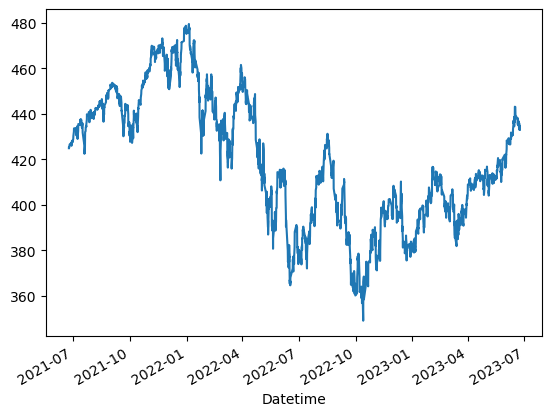

In [3]:
scraper.data["Open"].plot()

In [4]:
train_on = ["Open","High", "Low", "Close", "Volume"]
target = ["Close", "Volume"]
chart_train_column = 0

sf = StockForecast(
    epochs=200,lr=0.0001, 
    num_prediction_seq=100, num_training_seq=500,
    hidden_size=10, 
    gpu_device="mps", 
    train_on=train_on, target=target
)


# sf = StockForecaste(epochs=900,lr=0.001, hidden_size=20, gpu_device="mps")
sf.load(scraper.data, start_at = 0)
sf.normalize()
sf.sequence()
sf.create_model()
# sf.prepare()
# sf.create_model()


In [ ]:
loss_data = []
test_loss_data = []

for epoch in range(sf.epochs):
    sf.lstm.train()
    for train_tensors, test_tensors in sf.trainloader:    
        outputs = sf.lstm.forward(train_tensors)

        # calculate the gradient, manually setting to 0
        sf.optimizer.zero_grad()

        # obtain the loss function
        loss = sf.loss_fn(outputs, test_tensors[:,:,0]).to(sf.device)
        loss.backward()  # calculates the loss of the loss function
        sf.optimizer.step()  # improve from loss, i.e backprop
    
        loss_data.append(loss.item())

    sf.lstm.eval()
    for train_tensors, test_tensors in sf.testloader:        
        outputs = sf.lstm.forward(train_tensors)

        # calculate the gradient, manually setting to 0
        sf.optimizer.zero_grad()

        # obtain the loss function
        loss = sf.loss_fn(outputs, test_tensors[:,:,0]).to(sf.device)
        loss.backward()  # calculates the loss of the loss function
        sf.optimizer.step()  # improve from loss, i.e backprop
    
        test_loss_data.append(loss.item())   
    
    print(
        f"Epoch: {epoch}, train loss: {loss_data[-1]}, "
        f"test loss: {test_loss_data[-1]}"
    )
        

Epoch: 0, train loss: 0.003943684510886669, test loss: 0.021900774911046028
Epoch: 1, train loss: 0.0037952428683638573, test loss: 0.021543337032198906
Epoch: 2, train loss: 0.003939671907573938, test loss: 0.020253723487257957
Epoch: 3, train loss: 0.003969810903072357, test loss: 0.02298222854733467
Epoch: 4, train loss: 0.0038860749918967485, test loss: 0.023653648793697357
Epoch: 5, train loss: 0.00395425409078598, test loss: 0.024502919986844063
Epoch: 6, train loss: 0.0039288196712732315, test loss: 0.025202203541994095
Epoch: 7, train loss: 0.003957734908908606, test loss: 0.026159795001149178
Epoch: 8, train loss: 0.003958681132644415, test loss: 0.026794252917170525
Epoch: 9, train loss: 0.0038860333152115345, test loss: 0.027651559561491013
Epoch: 10, train loss: 0.0038708371575921774, test loss: 0.028592275455594063
Epoch: 11, train loss: 0.003989906050264835, test loss: 0.029408352449536324
Epoch: 12, train loss: 0.004157808609306812, test loss: 0.029804777354002
Epoch: 13

In [5]:
for data, train in sf.trainloader:
    print(data.shape), print(train.shape)
    break

torch.Size([16, 500, 3])
torch.Size([16, 100, 2])


#### Train Model

In [6]:
loss_data, test_loss_data = sf.train()

Epoch: 0, train loss: 0.3889009952545166, test loss: 0.38756951689720154
Epoch: 100, train loss: 0.003492781426757574, test loss: 0.0031866782810539007
Epoch: 200, train loss: 0.0022272258065640926, test loss: 0.0022603808902204037
Epoch: 300, train loss: 0.002152601722627878, test loss: 0.002249468117952347
Epoch: 400, train loss: 0.002115727635100484, test loss: 0.0022547864355146885
Epoch: 500, train loss: 0.0020944734569638968, test loss: 0.0022579494398087263
Epoch: 600, train loss: 0.00207690941169858, test loss: 0.0022417805157601833


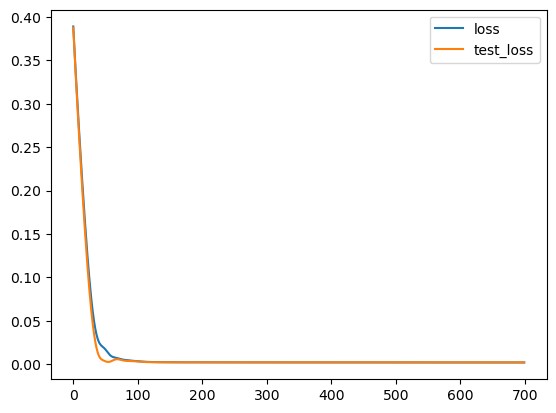

In [7]:
plt.plot(loss_data, label="loss")
plt.plot(test_loss_data, label="test_loss")
plt.legend()
plt.show()

#### Validate

<Axes: >

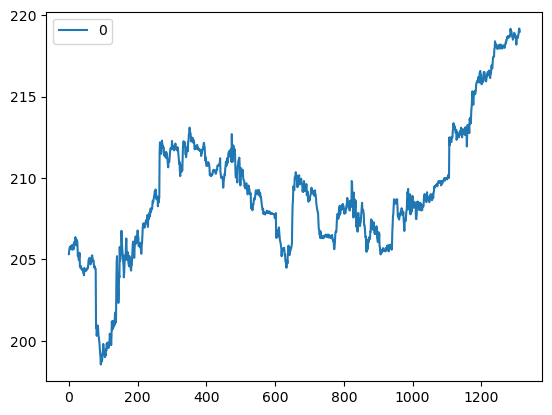

In [8]:
train_data = sf.ss.inverse_transform(sf.X_train_tensors.data.numpy()[:,0,:])[:,chart_train_column]
test_data = sf.mm.inverse_transform(sf.y_test_tensors)[:,chart_train_column]

train_predict = sf.lstm(sf.X_test_tensors) 
data_predict = sf.mm.inverse_transform(train_predict.data.numpy())[:,0]
pd.DataFrame(test_data).plot()

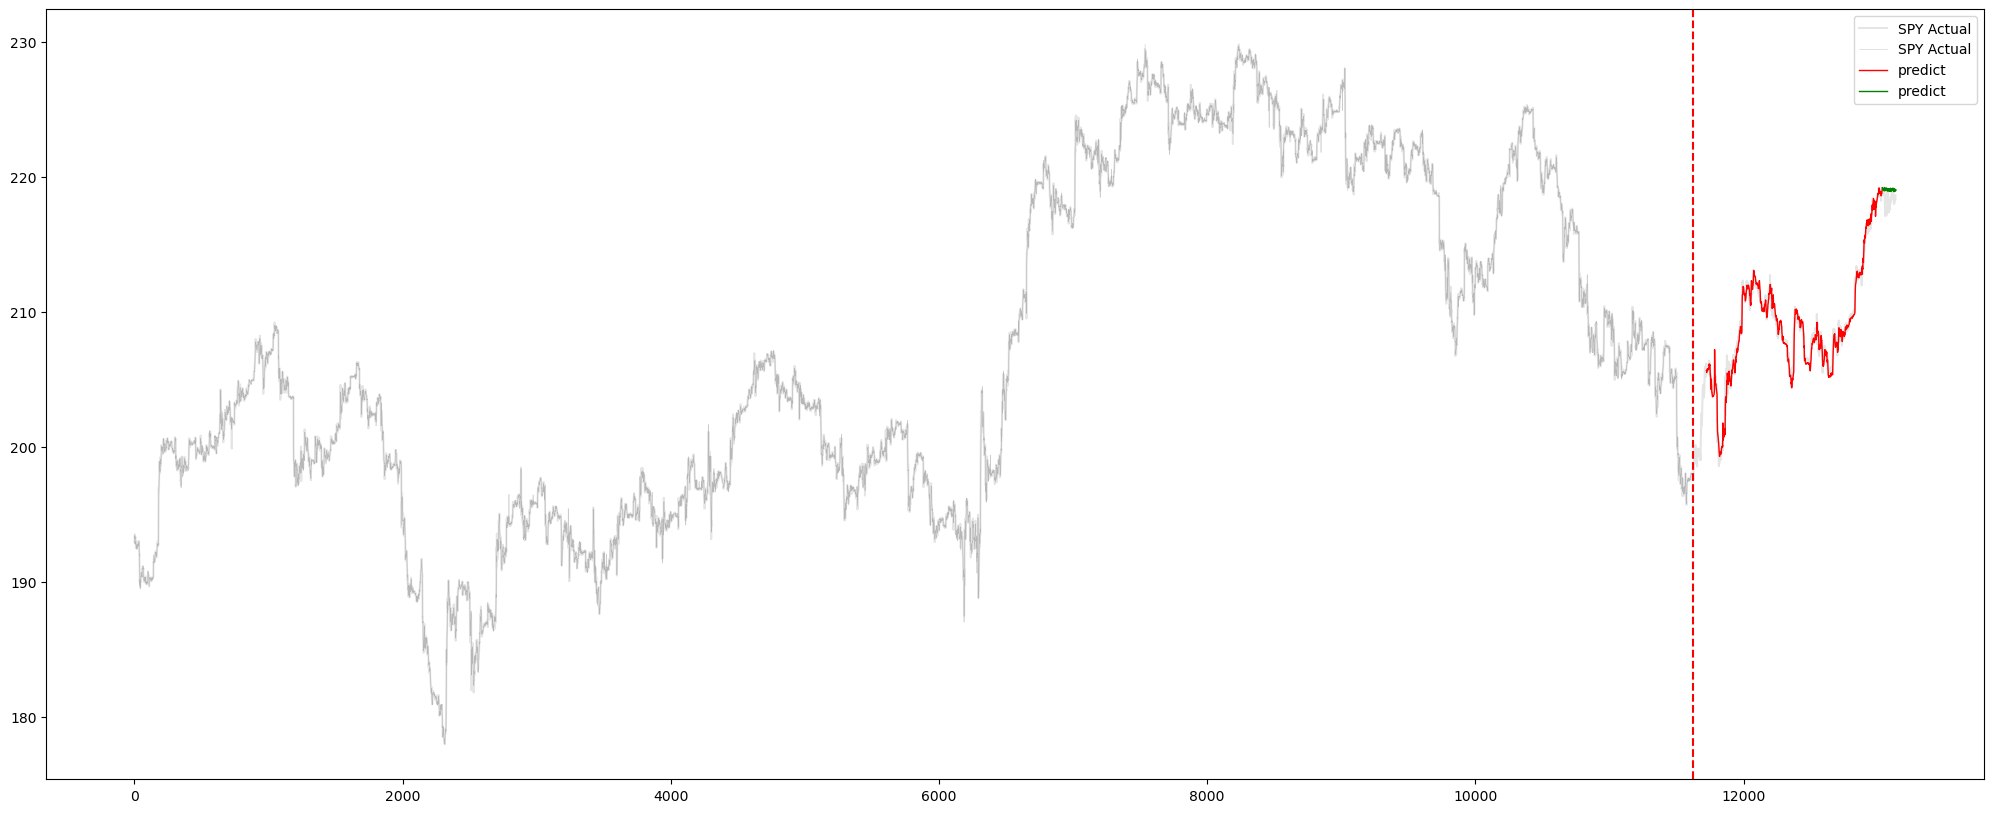

In [9]:
tdata_len = len(train_data)

plt.figure(figsize=(25,10)) #plotting

plt.plot(sf.mm.inverse_transform(sf.y_train), "k", label="SPY Actual", alpha=0.1)

plt.plot(train_data, "k", label="SPY Actual", alpha=0.2,linewidth=0.4)

# td = [None] * (tdata_len + 100)
# td.extend(test_data)
# plt.plot(td, "b", label="test", alpha=0.2,linewidth=0.4)

dp = [None] * (tdata_len + 100)
dp.extend(data_predict)
plt.plot(dp, "r", label="predict",linewidth=1)

test_predict = sf.lstm(sf.X_test_tensors[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = sf.mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

dp = [None] * (tdata_len + 100 + len(data_predict))
dp.extend(test_predict)
plt.plot(dp, "g", label="predict",linewidth=1)


plt.axvline(x=len(train_data), c='r', linestyle='--') # size of the training set

plt.legend()

plt.savefig(f"./images/full_prediction-{ticker}-{candlesize}.png", dpi=300)

plt.show()

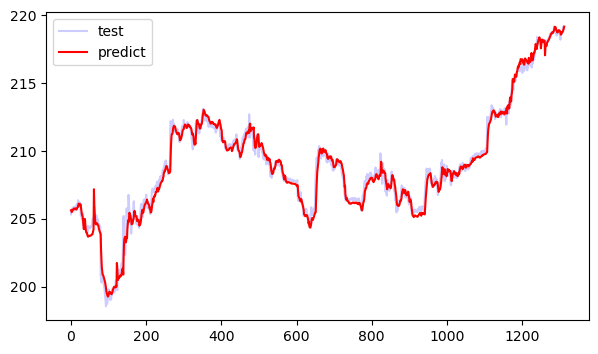

In [10]:
plt.figure(figsize=(7,4)) #plotting

td = test_data
plt.plot(td, "b", label="test", alpha=0.2)

dp = data_predict
plt.plot(dp, "r", label="predict")

plt.legend()
plt.savefig(f"./images/prediction-{ticker}-{candlesize}.png", dpi=300)

plt.show()

### Future Price

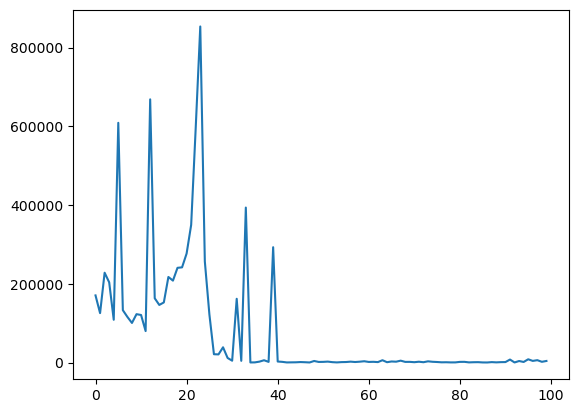

In [11]:
ds = sf.X_test_tensors[-1].unsqueeze(0)
plt.plot(sf.ss.inverse_transform(ds.detach().numpy()[0])[:, 0])

In [12]:
len(sf.X_train_tensors.data.numpy()) + len(sf.X_test_tensors.data.numpy())

12936

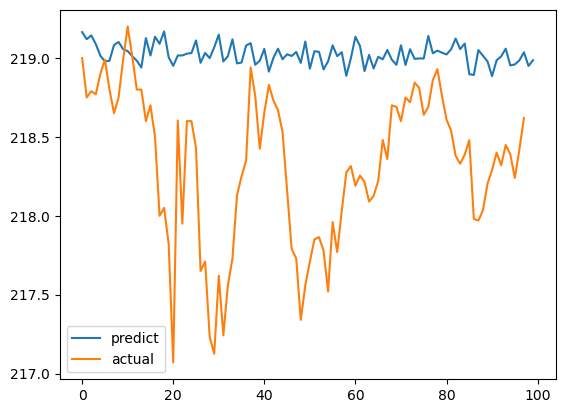

In [13]:
test_predict = sf.lstm(sf.X_test_tensors[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = sf.mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

known_length = len(sf.X_train_tensors.data.numpy()) + len(sf.X_test_tensors.data.numpy())
test_target = sf.raw_data.c[known_length+100:].reset_index(drop=True)
# test_target = sf.y_test_tensors[-1].detach().numpy() # last sample again
# test_target = sf.mm.inverse_transform(test_target.reshape(1, -1))
# test_target = test_target[0].tolist()

plt.plot(test_predict, label="predict")
plt.plot(test_target, label="actual")
plt.legend()
plt.savefig(f"./images/prediction_future-{ticker}-{candlesize}.png", dpi=300)

plt.show()